In [1]:
import argparse
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt

from BioMime.utils.basics import update_config, load_generator
from BioMime.utils.plot_functions import plot_muaps
from BioMime.utils.params import num_mus, steps, tgt_params
from BioMime.models.generator import Generator

from models import ConditionBiomime


In [2]:
from biomime_generator import *
from emg_processor import *

In [8]:
device = 'cuda:0'
config_path = './config/config.yaml'
model_checkpoint = './ckp/model_linear.pth'
biomime_gen = BiomimeMuapGenerator(config_path=config_path, model_checkpoint=model_checkpoint, device=device)


In [4]:
import torch
import numpy as np

class EMGDataset:
    def __init__(self, file_path):
        """
        Load dataset from an .npz file, including zi (Gaussian-related variable).
        """
        if not file_path.endswith(".npz"):
            raise ValueError("Only .npz file format is supported.")
        
        data = np.load(file_path)
        self.data_dict = {key: data[key] for key in data.files}
        self.tensors = {}

    def to_torch(self):
        """
        Convert all loaded numpy arrays into PyTorch tensors.
        """
        self.tensors = {key: torch.tensor(value, dtype=torch.float32) for key, value in self.data_dict.items()}

    def get_tensor(self, name):
        """
        Retrieve a specific tensor by name.
        """
        if name in self.tensors:
            return self.tensors[name]
        else:
            raise ValueError(f"Tensor '{name}' not found. Ensure you have called to_torch() first.")

    def to_device(self, device='cpu'):
        """
        Move tensors to GPU/CPU.
        """
        self.tensors = {key: tensor.to(device) for key, tensor in self.tensors.items()}

# Example usage
emg_data = EMGDataset("emg_data_10s_100MUs.npz")  # Load the dataset
emg_data.to_torch()  # Convert to torch tensors
emg_data.to_device('cuda')  # Move to GPU if needed

# Retrieve tensors (including zi)
tensor_emg = emg_data.get_tensor("emg")
tensor_zi = emg_data.get_tensor("zi")

print(tensor_emg.shape)  # Check shape
print(tensor_zi.shape)  # Ensure zi is correctly loaded


torch.Size([320, 20000])
torch.Size([1, 16])


In [5]:
device = 'cuda:0'
config_path = './config/config.yaml'
model_checkpoint = './ckp/model_linear.pth'
biomime_gen = BiomimeMuapGenerator(config_path=config_path, zi=emg_data.tensors['zi'].to(torch.float32), model_checkpoint=model_checkpoint, device=device)


In [6]:
n_mus_search = 10
cond = emg_data.tensors['base_conditions'][:n_mus_search]

In [127]:
import numpy as np

def create_tensor_with_grid(initial_tensor, i, j, N):
    """
    Creates an NxN,6 tensor where columns i and j contain a grid of values 
    (linspace between 0 and 1), and other columns retain values from the initial tensor.

    Parameters:
        initial_tensor (numpy.ndarray): A 1x6 tensor containing initial values.
        i (int): The index of the first column to be replaced with the grid.
        j (int): The index of the second column to be replaced with the grid.
        N (int): The size of the grid (NxN).

    Returns:
        numpy.ndarray: An NxN,6 tensor with the specified modifications.
    """
    # Create a linspace between 0 and 1 for the grid
    linspace_values = np.linspace(0, 1, N)
    grid_i, grid_j = np.meshgrid(linspace_values, linspace_values)

    # Create an NxN,6 tensor by broadcasting the initial tensor
    result_tensor = np.tile(initial_tensor, (N, N, 1))

    # Replace the i and j columns with the grid values
    result_tensor[..., i] = grid_i
    result_tensor[..., j] = grid_j

    return result_tensor

# Example usage

N = 100  # Grid size
cond_np = cond[3].cpu().numpy()
c_i = 0
c_j = 5
c_true = np.array([cond_np[c_i], cond_np[c_j]])
result = create_tensor_with_grid(cond_np, c_i, c_j, N)
print(result)


[[[0.         0.2839067  0.59277534 0.81977135 0.2332977  0.        ]
  [0.01010101 0.2839067  0.59277534 0.81977135 0.2332977  0.        ]
  [0.02020202 0.2839067  0.59277534 0.81977135 0.2332977  0.        ]
  ...
  [0.97979796 0.2839067  0.59277534 0.81977135 0.2332977  0.        ]
  [0.989899   0.2839067  0.59277534 0.81977135 0.2332977  0.        ]
  [1.         0.2839067  0.59277534 0.81977135 0.2332977  0.        ]]

 [[0.         0.2839067  0.59277534 0.81977135 0.2332977  0.01010101]
  [0.01010101 0.2839067  0.59277534 0.81977135 0.2332977  0.01010101]
  [0.02020202 0.2839067  0.59277534 0.81977135 0.2332977  0.01010101]
  ...
  [0.97979796 0.2839067  0.59277534 0.81977135 0.2332977  0.01010101]
  [0.989899   0.2839067  0.59277534 0.81977135 0.2332977  0.01010101]
  [1.         0.2839067  0.59277534 0.81977135 0.2332977  0.01010101]]

 [[0.         0.2839067  0.59277534 0.81977135 0.2332977  0.02020202]
  [0.01010101 0.2839067  0.59277534 0.81977135 0.2332977  0.02020202]
  [0

In [128]:
# Transfer everything needed to device
training_data = emg_data.tensors['extended_emg'].to(device)
cov = emg_data.tensors['covariance_matrix'].to(device)

In [129]:
torch.cuda.empty_cache()

bsize = 100
total = N*N
result_batched = result.reshape(-1, bsize, 6)
all_res = []
for i in tqdm(range(result_batched.shape[0])):
    all_res.append(biomime_gen(torch.tensor(result_batched[i]).cuda()).detach())

100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


In [130]:
hmap = torch.stack(all_res)
hmap = hmap.reshape(N*N, 96, 10, 32)
hmap = hmap.reshape(N*N, 96, 320).permute(0, 2, 1).to(torch.float32)
R = 10
filters = EMGProcessor.get_separation_vectors_torch(hmap, R=R)
mu1 = filters.T @  cov @ training_data
mu1.shape

torch.Size([10000, 20009])

In [131]:
from models import *

#loss = negen_loss(mu1)
loss = -torch_kurtosis(mu1)

<Axes: >

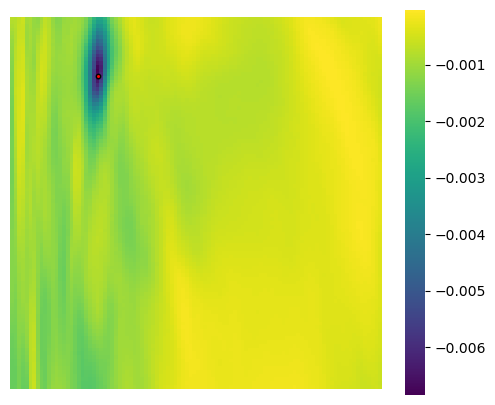

In [132]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def heatmap_with_point(heatmap, N, c_true):
    """
    Creates a heatmap of the log likelihoods with an input point plotted.

    Parameters:
        heatmap (torch.Tensor): A 1D tensor containing the log likelihood values.
        N (int): The size of the grid (NxN).
        c_true (tuple): A point (x, y) in normalized (0, 1) coordinates.

    Returns:
        matplotlib.axes.Axes: The Axes object containing the heatmap.
    """
    fig, ax = plt.subplots(figsize=(6, 5))  # Increase figure size for clarity

    # Create heatmap without axis labels
    sns.heatmap(
        heatmap.reshape(N, N).detach().cpu().numpy(), 
        ax=ax, 
        cbar=True, 
        square=True, 
        cmap="viridis"
    )

    # Convert c_true from (0,1) range to (0,N) range for plotting
    x_pixel = c_true[0] * (N - 1)
    y_pixel = c_true[1] * (N - 1)

    # Scatter plot the point on the heatmap
    ax.scatter(x_pixel + 0.5, y_pixel + 0.5, color='red', s=10, marker='o', edgecolors='black')

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    return ax

heatmap_with_point(loss, N, c_true)

<Axes: >

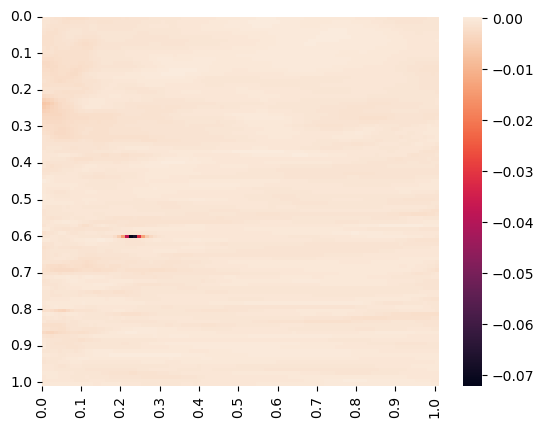

In [120]:
import seaborn as sns
import numpy as np

def heatmap_with_linspace(heatmap, N):
    """
    Creates a heatmap of the log likelihoods with custom linspace labels.

    Parameters:
        heatmap (torch.Tensor): A 1D tensor containing the log likelihood values.
        N (int): The size of the grid (NxN).

    Returns:
        seaborn.matrix.ClusterGrid: A Seaborn ClusterGrid object containing the heatmap.
    """
    # Create a Seaborn heatmap
    ax = sns.heatmap(heatmap.reshape(N, N).detach().cpu().numpy())
    
    # Set custom ticks and labels
    ticks = np.linspace(0, 1, 11)  # 0 to 1 with 0.1 intervals
    tick_labels = np.round(ticks, 1)
    
    ax.set_xticks(np.linspace(0, N-1, 11))
    ax.set_yticks(np.linspace(0, N-1, 11))
    
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    return ax

heatmap_with_linspace(loss, N)

In [173]:
emg_data.data_dict['base_conditions'][0]


array([1.        , 0.7183754 , 0.16400325, 0.7128613 , 0.8192431 ,
       0.47063142], dtype=float32)

In [196]:
loss_rep = loss.repeat(8, 1).detach().cpu().numpy()

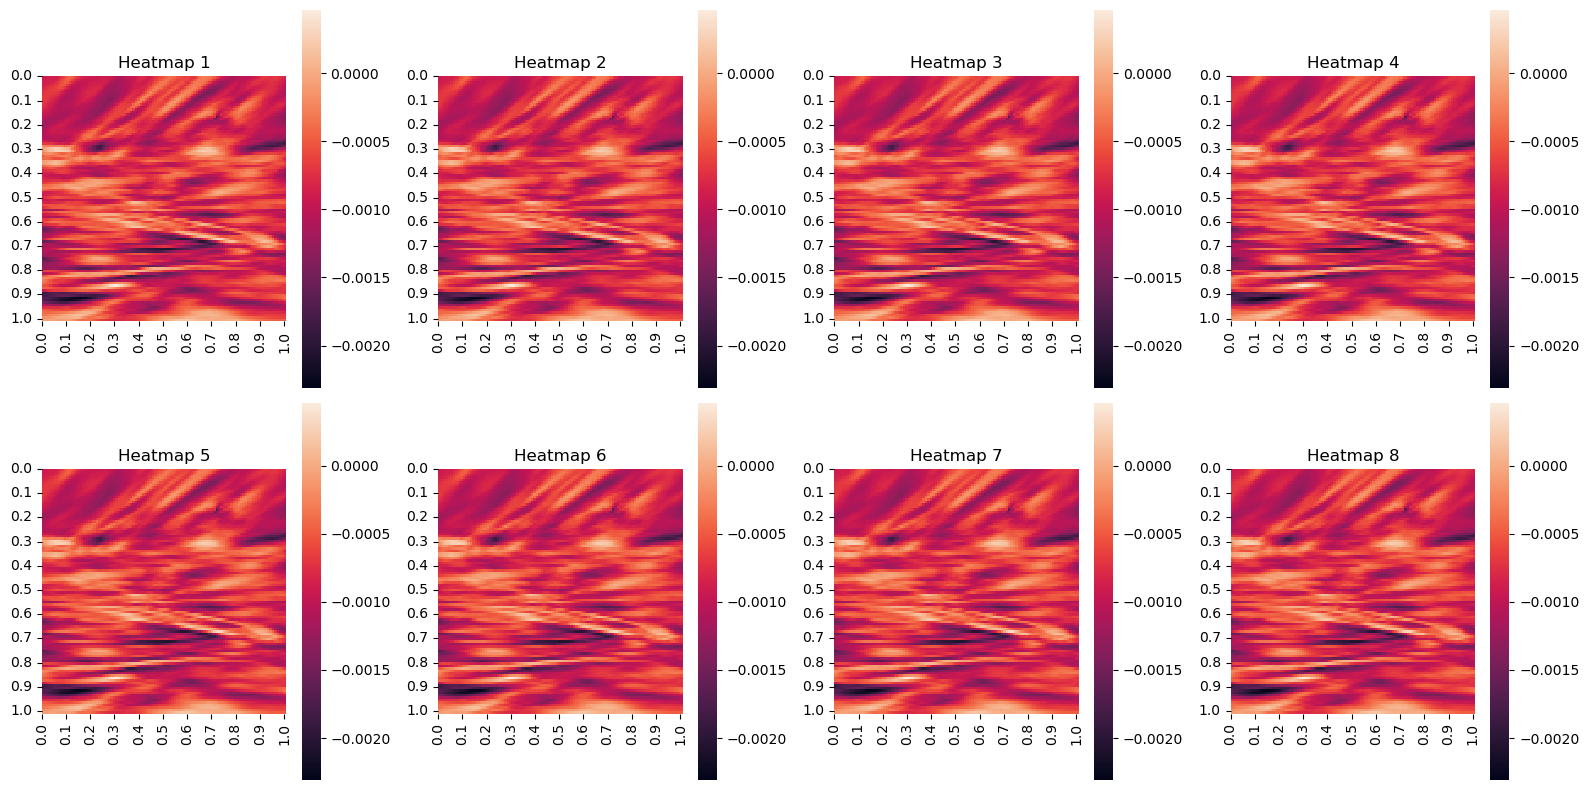

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_heatmap_grid(heatmaps, N):
    """
    Plots a 2x4 grid of heatmaps.

    Parameters:
        heatmaps (numpy.ndarray): A (8, N*N) numpy array containing the log likelihood values.
        N (int): The size of the grid (NxN).
    
    Returns:
        None
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    for i, ax in enumerate(axes.flat):
        sns.heatmap(
            heatmaps[i].reshape(N, N),
            ax=ax,
            cbar=True,
            square=True
        )
        ax.set_title(f'Heatmap {i+1}')
        
        # Set custom ticks and labels
        ticks = np.linspace(0, 1, 11)  # 0 to 1 with 0.1 intervals
        tick_labels = np.round(ticks, 1)

        ax.set_xticks(np.linspace(0, N - 1, 11))
        ax.set_yticks(np.linspace(0, N - 1, 11))

        ax.set_xticklabels(tick_labels)
        ax.set_yticklabels(tick_labels)

    plt.tight_layout()
    plt.show()

# # Example: Creating a random (8, N*N) numpy array
# N = 10
# heatmaps = np.random.rand(8, N * N)

# Plot the 2x4 grid of heatmaps
plot_heatmap_grid(loss_rep, N)



<Axes: >

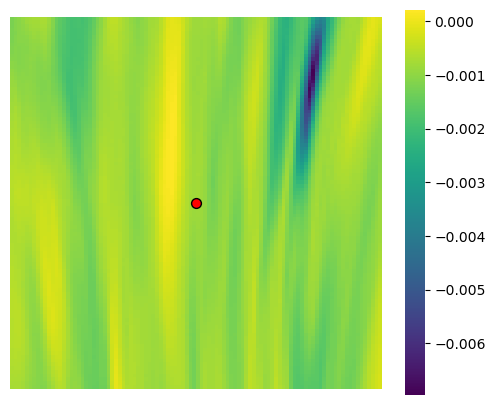

In [53]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def heatmap_with_point(heatmap, N, c_true):
    """
    Creates a heatmap of the log likelihoods with an input point plotted.

    Parameters:
        heatmap (torch.Tensor): A 1D tensor containing the log likelihood values.
        N (int): The size of the grid (NxN).
        c_true (tuple): A point (x, y) in normalized (0, 1) coordinates.

    Returns:
        matplotlib.axes.Axes: The Axes object containing the heatmap.
    """
    fig, ax = plt.subplots(figsize=(6, 5))  # Increase figure size for clarity

    # Create heatmap without axis labels
    sns.heatmap(
        heatmap.reshape(N, N).detach().cpu().numpy(), 
        ax=ax, 
        cbar=True, 
        square=True, 
        cmap="viridis"
    )

    # Convert c_true from (0,1) range to (0,N) range for plotting
    x_pixel = c_true[0] * (N - 1)
    y_pixel = c_true[1] * (N - 1)

    # Scatter plot the point on the heatmap
    ax.scatter(x_pixel + 0.5, y_pixel + 0.5, color='red', s=50, marker='o', edgecolors='black')

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    return ax

heatmap_with_point(loss, N, np.array([0.5, 0.5]))